In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

In [5]:
x_train

array([0.22222222, 1.        , 0.11111111, 0.55555556, 0.44444444,
       0.66666667, 0.        , 0.88888889, 0.77777778, 0.33333333])

In [6]:
y_train

array([ 0.97324599,  0.29116112,  0.96567557, -0.45622427,  0.38049931,
       -1.1694876 ,  0.41400875, -0.41846351, -0.63585247,  1.0517668 ])

In [7]:
x_test

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [8]:
y_test

array([ 0.00000000e+00,  6.34239197e-02,  1.26592454e-01,  1.89251244e-01,
        2.51147987e-01,  3.12033446e-01,  3.71662456e-01,  4.29794912e-01,
        4.86196736e-01,  5.40640817e-01,  5.92907929e-01,  6.42787610e-01,
        6.90079011e-01,  7.34591709e-01,  7.76146464e-01,  8.14575952e-01,
        8.49725430e-01,  8.81453363e-01,  9.09631995e-01,  9.34147860e-01,
        9.54902241e-01,  9.71811568e-01,  9.84807753e-01,  9.93838464e-01,
        9.98867339e-01,  9.99874128e-01,  9.96854776e-01,  9.89821442e-01,
        9.78802446e-01,  9.63842159e-01,  9.45000819e-01,  9.22354294e-01,
        8.95993774e-01,  8.66025404e-01,  8.32569855e-01,  7.95761841e-01,
        7.55749574e-01,  7.12694171e-01,  6.66769001e-01,  6.18158986e-01,
        5.67059864e-01,  5.13677392e-01,  4.58226522e-01,  4.00930535e-01,
        3.42020143e-01,  2.81732557e-01,  2.20310533e-01,  1.58001396e-01,
        9.50560433e-02,  3.17279335e-02, -3.17279335e-02, -9.50560433e-02,
       -1.58001396e-01, -

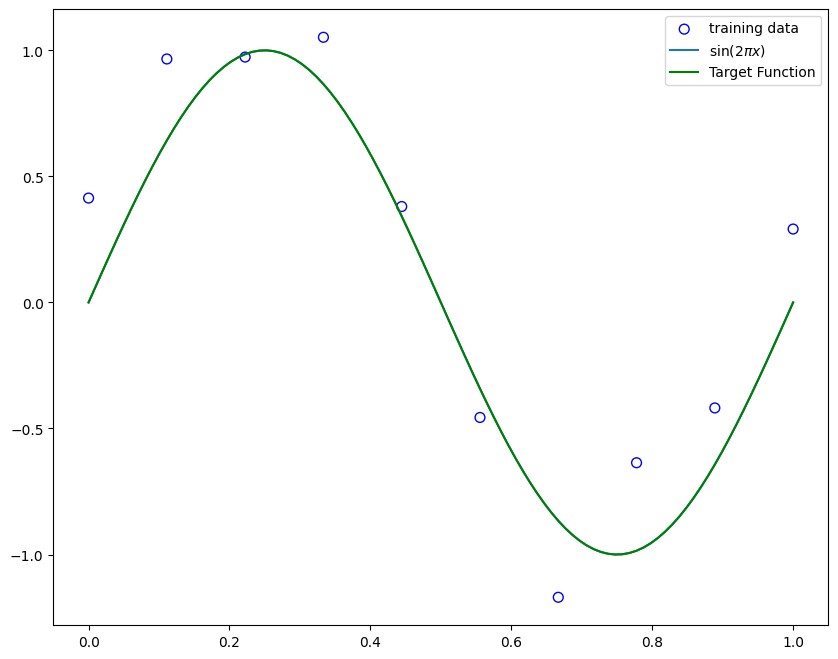

In [9]:
plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

In [10]:
weights = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)
cost = []

In [11]:
def stochastic_gradient_descent_pytorch(x, y, iterations=1000, learning_rate=0.01, stopping_threshold=1e-6):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    current_weight = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)
    current_bias = torch.tensor(0.01, dtype=torch.float32, requires_grad=True)

    costs = []
    previous_cost = None

    for i in range(iterations):
        for j in range(len(x_tensor)):
            x_sample = x_tensor[j]
            y_sample = y_tensor[j]

            y_predicted = current_weight * x_sample + current_bias
            
            current_cost = (y_sample - y_predicted) ** 2 #MSE
            
            if previous_cost is not None and abs(previous_cost.item() - current_cost.item()) <= stopping_threshold:
                break
            
            previous_cost = current_cost

            current_weight.grad = None  
            current_bias.grad = None
            
            current_cost.backward()  

            with torch.no_grad():
                current_weight -= learning_rate * current_weight.grad
                current_bias -= learning_rate * current_bias.grad
                mean_cost = ((y_tensor - (current_weight * x_tensor + current_bias)) ** 2).mean()
        costs.append(mean_cost.item())
        if (i + 1) % 1000 == 0 or i == 0:  
            print(f"Iteration {i + 1}: Mean Cost {mean_cost.item()}, Weight {current_weight.item()}, Bias {current_bias.item()}")

    return current_weight.item(), current_bias.item(), costs


# weight, bias, costs = stochastic_gradient_descent_pytorch(x, y)

In [12]:
weights, bias, cost = stochastic_gradient_descent_pytorch(x_train, y_train)

Iteration 1: Mean Cost 0.5635138750076294, Weight 0.07499651610851288, Bias 0.022939695045351982
Iteration 1000: Mean Cost 0.3246017098426819, Weight -1.4351868629455566, Bias 0.8457285165786743


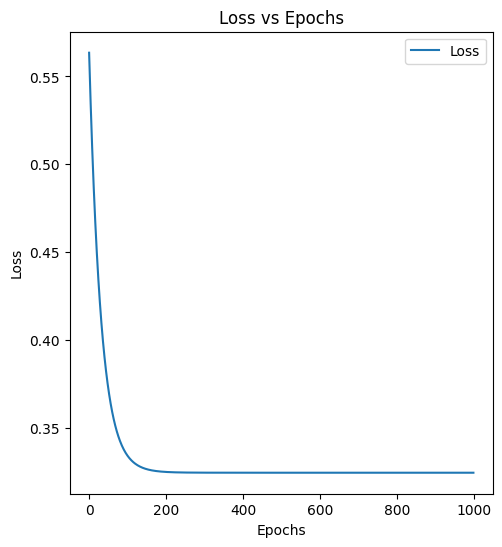

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cost, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

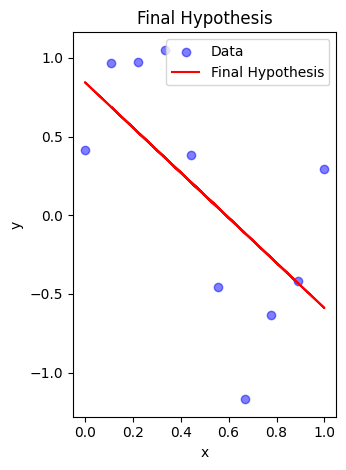

In [14]:
plt.subplot(1, 2, 2)
plt.scatter(x_train, y_train, label='Data', color='blue', alpha=0.5)
plt.plot(x_train, weights * x_train + bias, label='Final Hypothesis', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Final Hypothesis')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(x_test_tensor)

Epoch [100/1000], Loss: 0.2174
Epoch [200/1000], Loss: 0.1889
Epoch [300/1000], Loss: 0.1860
Epoch [400/1000], Loss: 0.1858
Epoch [500/1000], Loss: 0.1858
Epoch [600/1000], Loss: 0.1858
Epoch [700/1000], Loss: 0.1858
Epoch [800/1000], Loss: 0.1858
Epoch [900/1000], Loss: 0.1858
Epoch [1000/1000], Loss: 0.1858


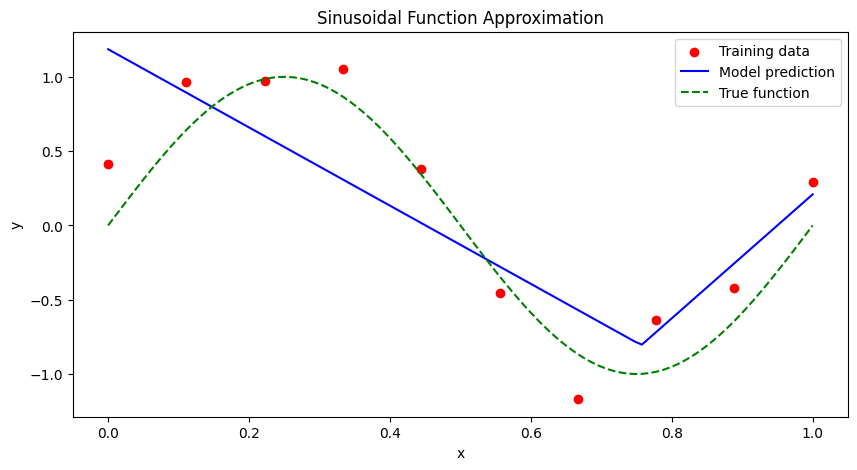

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='red', label='Training data')
plt.plot(x_test, y_pred.numpy(), color='blue', label='Model prediction')
plt.plot(x_test, y_test, color='green', linestyle='--', label='True function')
plt.title('Sinusoidal Function Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [17]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


In [18]:
dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(str),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
      }
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.to_datetime(val, format ='%y%m%d%H')

In [19]:
train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)

/tmp/ipykernel_160/789021288.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)


In [20]:
train

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000679056417042096,0,2014-10-21 00:00:00,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10000918755742328737,0,2014-10-21 00:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20632,320,50,2374,3,39,-1,23
2,10001264480619467364,0,2014-10-21 00:00:00,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21689,320,50,2496,3,167,100191,23
3,10002028568167339219,0,2014-10-21 00:00:00,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,...,1,2,20596,320,50,2161,0,35,100148,157
4,10007944429976961145,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,9993293777749289971,1,2014-10-30 23:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,-1,79
4999996,9993490976166478268,0,2014-10-30 23:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,d36838b1,0e8616ad,...,1,0,23866,320,50,2736,0,33,100170,246
4999997,9995064718229733761,0,2014-10-30 23:00:00,1002,0,c135a32f,b8393312,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
4999998,9998205295831446187,0,2014-10-30 23:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,1,0,18648,320,50,1092,3,809,100156,61


In [21]:
train.dropna()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000679056417042096,0,2014-10-21 00:00:00,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10000918755742328737,0,2014-10-21 00:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20632,320,50,2374,3,39,-1,23
2,10001264480619467364,0,2014-10-21 00:00:00,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21689,320,50,2496,3,167,100191,23
3,10002028568167339219,0,2014-10-21 00:00:00,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,...,1,2,20596,320,50,2161,0,35,100148,157
4,10007944429976961145,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,9993293777749289971,1,2014-10-30 23:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,-1,79
4999996,9993490976166478268,0,2014-10-30 23:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,d36838b1,0e8616ad,...,1,0,23866,320,50,2736,0,33,100170,246
4999997,9995064718229733761,0,2014-10-30 23:00:00,1002,0,c135a32f,b8393312,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
4999998,9998205295831446187,0,2014-10-30 23:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,1,0,18648,320,50,1092,3,809,100156,61


In [22]:
train.shape

(5000000, 24)

In [ ]:
#train.value_counts()

In [ ]:
#train.sum()

In [23]:
print(train.columns)

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')


In [24]:
train.set_index('hour',inplace=True)

In [25]:
train.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,
2014-10-21 00:00:00,10000679056417042096,0,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,...,1,0,18993,320,50,2161,0,35,-1,157
2014-10-21 00:00:00,10000918755742328737,0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,20632,320,50,2374,3,39,-1,23
2014-10-21 00:00:00,10001264480619467364,0,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,21689,320,50,2496,3,167,100191,23
2014-10-21 00:00:00,10002028568167339219,0,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,...,1,2,20596,320,50,2161,0,35,100148,157
2014-10-21 00:00:00,10007944429976961145,1,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15701,320,50,1722,0,35,-1,79


In [26]:
df = train[:3000]
sparse_features = df.iloc[::,2:14].values.tolist()
dense_features = df.iloc[::,15:].values.tolist()
sparse_features.append('id')
label = df['click']

In [27]:
sparse_features

[['1005',
  '1',
  'fe8cc448',
  '9166c161',
  '0569f928',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'a99f214a',
  '9644d0bf',
  '779d90c2',
  '1'],
 ['1005',
  '1',
  'e151e245',
  '7e091613',
  'f028772b',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'a99f214a',
  'e6f67278',
  'be74e6fe',
  '1'],
 ['1002',
  '0',
  '84c7ba46',
  'c4e18dd6',
  '50e219e0',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'c357dbff',
  'f1ac7184',
  '373ecbe6',
  '0'],
 ['1005',
  '0',
  '9e8cf15d',
  '0d3cb7be',
  'f028772b',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'a99f214a',
  '58811cdf',
  '8326c04b',
  '1'],
 ['1005',
  '0',
  '1fbe01fe',
  'f3845767',
  '28905ebd',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'a99f214a',
  '07875ea4',
  'aaffed8f',
  '1'],
 ['1005',
  '0',
  '4dd0a958',
  '79cf0c8d',
  'f028772b',
  'ecad2386',
  '7801e8d9',
  '07d7df22',
  'a99f214a',
  'f6a5ae09',
  '88fe1d5d',
  '1'],
 ['1005',
  '0',
  '85f751fd',
  'c4e18dd6',
  '50e219e0',
  '0acbeaa3',
  '45a51db4',
  'f95e

In [28]:
dense_features

[['18993', '320', '50', '2161', '0', '35', '-1', '157'],
 ['20632', '320', '50', '2374', '3', '39', '-1', '23'],
 ['21689', '320', '50', '2496', '3', '167', '100191', '23'],
 ['20596', '320', '50', '2161', '0', '35', '100148', '157'],
 ['15701', '320', '50', '1722', '0', '35', '-1', '79'],
 ['20366', '320', '50', '2333', '0', '39', '-1', '157'],
 ['20596', '320', '50', '2161', '0', '35', '100034', '157'],
 ['15699', '320', '50', '1722', '0', '35', '-1', '79'],
 ['15702', '320', '50', '1722', '0', '35', '-1', '79'],
 ['15704', '320', '50', '1722', '0', '35', '-1', '79'],
 ['15701', '320', '50', '1722', '0', '35', '100084', '79'],
 ['19743', '320', '50', '2264', '3', '427', '100000', '61'],
 ['18993', '320', '50', '2161', '0', '35', '-1', '157'],
 ['20366', '320', '50', '2333', '0', '39', '-1', '157'],
 ['15705', '320', '50', '1722', '0', '35', '-1', '79'],
 ['17661', '320', '50', '1996', '1', '41', '100057', '71'],
 ['15705', '320', '50', '1722', '0', '35', '100084', '79'],
 ['18993', '

In [29]:
def min_max_scaler(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [30]:
label_mapping = {}
label_encoded_arrays = []

unique_labels = set(value for array in sparse_features for value in array)
for index, label in enumerate(unique_labels):
    label_mapping[label] = index

for array in sparse_features:
    encoded_array = [label_mapping[value] for value in array]
    label_encoded_arrays.append(encoded_array)

In [31]:
label_encoded_arrays

[[1237, 1309, 3221, 477, 1671, 1739, 3027, 2994, 1927, 1806, 3820, 1309],
 [1237, 1309, 2754, 276, 254, 1739, 3027, 2994, 1927, 2701, 2897, 1309],
 [3290, 82, 1423, 636, 1918, 1739, 3027, 2994, 3585, 3256, 646, 82],
 [1237, 82, 1764, 1005, 254, 1739, 3027, 2994, 1927, 2351, 482, 1309],
 [1237, 82, 3933, 242, 2312, 1739, 3027, 2994, 1927, 922, 1983, 1309],
 [1237, 82, 3141, 1915, 254, 1739, 3027, 2994, 1927, 4112, 3113, 1309],
 [1237, 82, 2478, 636, 1918, 3693, 1470, 2999, 1927, 1942, 3334, 1309],
 [1237, 82, 3933, 242, 2312, 1739, 3027, 2994, 1927, 922, 792, 1309],
 [1237, 82, 3933, 242, 2312, 1739, 3027, 2994, 1927, 3272, 345, 1309],
 [1237, 82, 3933, 242, 2312, 1739, 3027, 2994, 1927, 986, 2093, 1309],
 [1237, 82, 3933, 242, 2312, 1739, 3027, 2994, 1927, 2320, 1264, 1309],
 [1237, 82, 2478, 636, 1918, 2902, 83, 295, 1927, 90, 1871, 1309],
 [1237, 82, 2478, 636, 1918, 2932, 2666, 2999, 1927, 4030, 3639, 1309],
 [1237, 82, 3397, 4086, 605, 1739, 3027, 2994, 1927, 1941, 1084, 1309],
 [1

In [32]:
sparse_df = pd.DataFrame(label_encoded_arrays, columns = ['C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type'] )
sparse_df

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type
0,1237,1309,3221.0,477.0,1671.0,1739.0,3027.0,2994.0,1927.0,1806.0,3820.0,1309.0
1,1237,1309,2754.0,276.0,254.0,1739.0,3027.0,2994.0,1927.0,2701.0,2897.0,1309.0
2,3290,82,1423.0,636.0,1918.0,1739.0,3027.0,2994.0,3585.0,3256.0,646.0,82.0
3,1237,82,1764.0,1005.0,254.0,1739.0,3027.0,2994.0,1927.0,2351.0,482.0,1309.0
4,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,922.0,1983.0,1309.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2996,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,1383.0,3116.0,1309.0
2997,1237,1309,2272.0,276.0,254.0,1739.0,3027.0,2994.0,1927.0,2194.0,3782.0,1309.0
2998,1237,1309,3222.0,2067.0,254.0,1739.0,3027.0,2994.0,1927.0,3648.0,1501.0,1309.0
2999,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,2290.0,792.0,1309.0


In [33]:
dense_df = pd.DataFrame(dense_features, columns = ['C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'])
dense_df

,C14,C15,C16,C17,C18,C19,C20,C21
0,18993,320,50,2161,0,35,-1,157
1,20632,320,50,2374,3,39,-1,23
2,21689,320,50,2496,3,167,100191,23
3,20596,320,50,2161,0,35,100148,157
4,15701,320,50,1722,0,35,-1,79
...,...,...,...,...,...,...,...,...
2995,20596,320,50,2161,0,35,-1,157
2996,15703,320,50,1722,0,35,-1,79
2997,9478,320,50,906,3,1451,100156,61
2998,19772,320,50,2227,0,687,100081,48


In [35]:
concat_rows = pd.concat([sparse_df, dense_df], axis=1)

In [36]:
concat_rows

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1237,1309,3221.0,477.0,1671.0,1739.0,3027.0,2994.0,1927.0,1806.0,3820.0,1309.0,18993,320,50,2161,0,35,-1,157
1,1237,1309,2754.0,276.0,254.0,1739.0,3027.0,2994.0,1927.0,2701.0,2897.0,1309.0,20632,320,50,2374,3,39,-1,23
2,3290,82,1423.0,636.0,1918.0,1739.0,3027.0,2994.0,3585.0,3256.0,646.0,82.0,21689,320,50,2496,3,167,100191,23
3,1237,82,1764.0,1005.0,254.0,1739.0,3027.0,2994.0,1927.0,2351.0,482.0,1309.0,20596,320,50,2161,0,35,100148,157
4,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,922.0,1983.0,1309.0,15701,320,50,1722,0,35,-1,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,1383.0,3116.0,1309.0,15703,320,50,1722,0,35,-1,79
2997,1237,1309,2272.0,276.0,254.0,1739.0,3027.0,2994.0,1927.0,2194.0,3782.0,1309.0,9478,320,50,906,3,1451,100156,61
2998,1237,1309,3222.0,2067.0,254.0,1739.0,3027.0,2994.0,1927.0,3648.0,1501.0,1309.0,19772,320,50,2227,0,687,100081,48
2999,1237,82,3933.0,242.0,2312.0,1739.0,3027.0,2994.0,1927.0,2290.0,792.0,1309.0,15704,320,50,1722,0,35,-1,79


In [37]:
concat_rows.dtypes

C1                 int64
banner_pos         int64
site_id          float64
site_domain      float64
site_category    float64
app_id           float64
app_domain       float64
app_category     float64
device_id        float64
device_ip        float64
device_model     float64
device_type      float64
C14               object
C15               object
C16               object
C17               object
C18               object
C19               object
C20               object
C21               object
dtype: object

In [38]:
def convert_to_int(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].astype('Int64')
        except Exception as e:
            print(f"Could not convert column {col}: {e}")
    return df

concat_rows = convert_to_int(concat_rows)
concat_rows

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1237,1309,3221,477,1671,1739,3027,2994,1927,1806,3820,1309,18993,320,50,2161,0,35,-1,157
1,1237,1309,2754,276,254,1739,3027,2994,1927,2701,2897,1309,20632,320,50,2374,3,39,-1,23
2,3290,82,1423,636,1918,1739,3027,2994,3585,3256,646,82,21689,320,50,2496,3,167,100191,23
3,1237,82,1764,1005,254,1739,3027,2994,1927,2351,482,1309,20596,320,50,2161,0,35,100148,157
4,1237,82,3933,242,2312,1739,3027,2994,1927,922,1983,1309,15701,320,50,1722,0,35,-1,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,1237,82,3933,242,2312,1739,3027,2994,1927,1383,3116,1309,15703,320,50,1722,0,35,-1,79
2997,1237,1309,2272,276,254,1739,3027,2994,1927,2194,3782,1309,9478,320,50,906,3,1451,100156,61
2998,1237,1309,3222,2067,254,1739,3027,2994,1927,3648,1501,1309,19772,320,50,2227,0,687,100081,48
2999,1237,82,3933,242,2312,1739,3027,2994,1927,2290,792,1309,15704,320,50,1722,0,35,-1,79


In [39]:
data_df = min_max_scaler(concat_rows)
data_df

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0.0,0.536511,0.77039,0.106079,0.609725,0.410275,0.781524,0.735022,0.457843,0.431199,0.913376,0.32298,0.872937,1.0,0.031532,0.859119,0.0,0.0,0.0,1.0
1,0.0,0.536511,0.658694,0.057399,0.0,0.410275,0.781524,0.735022,0.457843,0.645007,0.69251,0.32298,0.949784,1.0,0.031532,0.948428,1.0,0.002222,0.0,0.069444
2,0.812104,0.0,0.340349,0.144587,0.716007,0.410275,0.781524,0.735022,0.856113,0.777592,0.153865,0.0,0.999344,1.0,0.031532,0.999581,1.0,0.073333,0.999431,0.069444
3,0.0,0.0,0.421909,0.233955,0.0,0.410275,0.781524,0.735022,0.457843,0.561395,0.114621,0.32298,0.948096,1.0,0.031532,0.859119,0.0,0.0,0.999002,1.0
4,0.0,0.0,0.940684,0.049164,0.885542,0.410275,0.781524,0.735022,0.457843,0.220019,0.473798,0.32298,0.718586,1.0,0.031532,0.675052,0.0,0.0,0.0,0.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.0,0.0,0.940684,0.049164,0.885542,0.410275,0.781524,0.735022,0.457843,0.330148,0.744915,0.32298,0.71868,1.0,0.031532,0.675052,0.0,0.0,0.0,0.458333
2997,0.0,0.536511,0.543411,0.057399,0.0,0.410275,0.781524,0.735022,0.457843,0.523889,0.904283,0.32298,0.42681,1.0,0.031532,0.332914,1.0,0.786667,0.999082,0.333333
2998,0.0,0.536511,0.770629,0.49116,0.0,0.410275,0.781524,0.735022,0.457843,0.871237,0.358459,0.32298,0.909462,1.0,0.031532,0.886792,0.0,0.362222,0.998334,0.243056
2999,0.0,0.0,0.940684,0.049164,0.885542,0.410275,0.781524,0.735022,0.457843,0.546823,0.188801,0.32298,0.718727,1.0,0.031532,0.675052,0.0,0.0,0.0,0.458333


In [40]:
data_df.dropna()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0.0,0.536511,0.77039,0.106079,0.609725,0.410275,0.781524,0.735022,0.457843,0.431199,0.913376,0.32298,0.872937,1.0,0.031532,0.859119,0.0,0.0,0.0,1.0
1,0.0,0.536511,0.658694,0.057399,0.0,0.410275,0.781524,0.735022,0.457843,0.645007,0.69251,0.32298,0.949784,1.0,0.031532,0.948428,1.0,0.002222,0.0,0.069444
2,0.812104,0.0,0.340349,0.144587,0.716007,0.410275,0.781524,0.735022,0.856113,0.777592,0.153865,0.0,0.999344,1.0,0.031532,0.999581,1.0,0.073333,0.999431,0.069444
3,0.0,0.0,0.421909,0.233955,0.0,0.410275,0.781524,0.735022,0.457843,0.561395,0.114621,0.32298,0.948096,1.0,0.031532,0.859119,0.0,0.0,0.999002,1.0
4,0.0,0.0,0.940684,0.049164,0.885542,0.410275,0.781524,0.735022,0.457843,0.220019,0.473798,0.32298,0.718586,1.0,0.031532,0.675052,0.0,0.0,0.0,0.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.037072,0.173165,0.046472,0.410275,0.781524,0.735022,0.457843,0.047539,0.20603,0.32298,0.948096,1.0,0.031532,0.859119,0.0,0.0,0.0,1.0
2996,0.0,0.0,0.940684,0.049164,0.885542,0.410275,0.781524,0.735022,0.457843,0.330148,0.744915,0.32298,0.71868,1.0,0.031532,0.675052,0.0,0.0,0.0,0.458333
2997,0.0,0.536511,0.543411,0.057399,0.0,0.410275,0.781524,0.735022,0.457843,0.523889,0.904283,0.32298,0.42681,1.0,0.031532,0.332914,1.0,0.786667,0.999082,0.333333
2998,0.0,0.536511,0.770629,0.49116,0.0,0.410275,0.781524,0.735022,0.457843,0.871237,0.358459,0.32298,0.909462,1.0,0.031532,0.886792,0.0,0.362222,0.998334,0.243056


In [41]:
data_df.dtypes

C1               Float64
banner_pos       Float64
site_id          Float64
site_domain      Float64
site_category    Float64
app_id           Float64
app_domain       Float64
app_category     Float64
device_id        Float64
device_ip        Float64
device_model     Float64
device_type      Float64
C14              Float64
C15              Float64
C16              Float64
C17              Float64
C18              Float64
C19              Float64
C20              Float64
C21              Float64
dtype: object

In [45]:
X = data_df.dropna().to_numpy(dtype = 'float64')
y = df[['click']].values

In [46]:
X

array([[0.        , 0.53651071, 0.77038986, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.53651071, 0.65869409, ..., 0.00222222, 0.        ,
        0.06944444],
       [0.81210443, 0.        , 0.3403492 , ..., 0.07333333, 0.99943142,
        0.06944444],
       ...,
       [0.        , 0.53651071, 0.54341067, ..., 0.78666667, 0.99908229,
        0.33333333],
       [0.        , 0.53651071, 0.77062904, ..., 0.36222222, 0.99833415,
        0.24305556],
       [0.        , 0.        , 0.94068405, ..., 0.        , 0.        ,
        0.45833333]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [56]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [53]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

In [54]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [57]:
num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad() #so gradiest are set back to zero
    loss.backward() 
    optimizer.step()


In [60]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted = (test_outputs >= 0.5).float()

In [61]:
y_test_numpy = y_test_tensor.numpy()
predicted_numpy = predicted.numpy()

accuracy = accuracy_score(y_test_numpy, predicted_numpy)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 80.67%


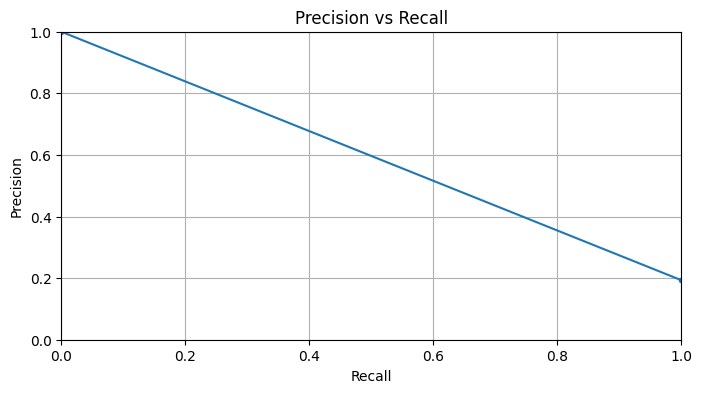

In [71]:
precision, recall, _ = precision_recall_curve(y_test_numpy, predicted_numpy)
plt.figure(figsize=(8, 4))
plt.plot(recall, precision, marker='.')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

Precision is the ratio of true positive predictions to the total predicted positives
Recall is the ratio of true positive predictions to the actual positives 
Increasing precision reduces recall and vice versa
My curve starts from 1 and ends towards 0.2 thus my minimun precision is 0.2 meaning at maximum recall only 20 percent of my values are correctly processed and rest are false positives. 